In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = torch.tanh(layer(x))
        x = self.linears[-1](x)
        return(x)

In [3]:
def nonRepeatedRandomInt(low, upper, N):
        import numpy as np
        import random
        
        numbers = np.arange(low, upper, 1)
        random.shuffle(numbers)
        shuffleNumbers = np.array(numbers)[0:int(N)]
        shuffleNumbers = np.sort(shuffleNumbers)
        
        return shuffleNumbers

In [4]:
def print_results(file, idx, net_param, ncamadas, n_features, features_col, features_name, random_state, data_train, data_train_resample, test_loss, test_cos_sim, net):
    import csv
    
    
    headerCSVList= []
   
    headerCSVList.append('index')
    headerCSVList.append('net_param')
    headerCSVList.append('ncamadas')
    headerCSVList.append('n_features')
    headerCSVList.append('features_col')
    headerCSVList.append('features_name')
    headerCSVList.append('random_state')
    headerCSVList.append('data_train')
    headerCSVList.append('data_train_resample')
    headerCSVList.append('test_loss')
    headerCSVList.append('test_cos_sim')
    headerCSVList.append('net')
    
    #---printing file results---------
    rowCSVList=[]   
    rowCSVList.append(idx)
    rowCSVList.append(net_param)
    rowCSVList.append(ncamadas)
    rowCSVList.append(n_features)
    rowCSVList.append(features_col)
    rowCSVList.append(features_name)
    rowCSVList.append(random_state)
    rowCSVList.append(data_train)
    rowCSVList.append(data_train_resample)
    rowCSVList.append(test_loss)
    rowCSVList.append(test_cos_sim)
    rowCSVList.append(net)
    
   
    with open(file, 'a') as csvfileWrite:
        spamwriter = csv.writer(csvfileWrite, delimiter=',')
        if idx==50000:
            spamwriter.writerow(headerCSVList)
           
        spamwriter.writerow(rowCSVList)

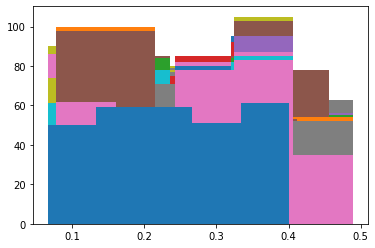

In [5]:
for teste in range(66601, 100000):
    data = pd.read_pickle("data_closed_rigid_o")
    pf50 = data["PF50_closed_rigid"].values

    # Sortear quais caracteristicas usar
    n_features = np.random.randint(low=1, high=26)
    #print('Numero de features: %d' % (n_features))
    columns = nonRepeatedRandomInt(low=0, upper=183, N=n_features)
    #print(columns)

    features = data.iloc[:,columns]
    features_names = features.columns
    X = features.values
    y = pf50.reshape(len(pf50), 1)

    # Separando o dataset em treino e teste
    random_state =  np.random.randint(low=1, high=100)
    #print('Random State: %d' % (random_state))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # Histograma dos dados de treino
    for nbins in range(10,1,-1):
        n, bins, patches = plt.hist(y_train, nbins)
        if np.min(n)>3:
            break

    # Indica qual o bin correspondente para cada dado
    indices = np.digitize(y_train, bins)

    # Arrumar o caso do último valor que não é incluído no último bin
    indices[indices>nbins]=nbins
    indices = indices.reshape(len(indices),)

    # SMOTE - Data Augmentation
    data_train = np.hstack([X_train, y_train])
    sm = SMOTE(k_neighbors=np.int(n.min()-1), random_state=42)
    data_train_res, indices_res = sm.fit_resample(data_train, indices)

    # Histograma dos dados de treino resample
    nbins = 5
    n_res, bins_res, patches_res = plt.hist(data_train_res[:,-1], nbins)

    # Declarando o dado resample como dado de treino
    X_train = data_train_res[:,0:-1]
    y_train = data_train_res[:,-1].reshape(data_train_res.shape[0],1)

    # Ajustando o escalamento ao dado de TREINAMENTO (fit) e transformando o dado de treinamento
    scaler_x = MinMaxScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)

    torch.manual_seed(1234)

    num_layers = np.random.randint(low=3, high=10)
    #print('Number of layers: %d' % (num_layers))
    layer_init_size = np.random.randint(low=1, high=20)
    #print('Inicial size layer: %d' % (layer_init_size))
    layers_size = np.linspace(layer_init_size, 1, num_layers-1, dtype=int)
    #print(layers_size)

    net = Net(input_size=X.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=1)

    # Choose optmizer and loss function
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.05, momentum = 0.9) # lr = learning rate

    # Treinamento utilizando o dado de treino transformado
    epochs = 5000
    lossr = np.zeros(epochs)

    for epoch in range(epochs):
        inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
        targets = torch.autograd.Variable(torch.Tensor(y_train_scaled.astype(np.float32)).float())

        optimizer.zero_grad()
        out = net(inputs)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()

        lossr[epoch] = loss.item()

        #if epoch == 0 or (epoch + 1) % 10 == 0:
            #print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))

    torch.save(net.state_dict(), 'F:\\Priscila Acamine\\TG-Biomed\\Nets2_50000\\net_'+str(teste))

    epoch = np.arange(0, epochs)
    # plt.plot(epoch,lossr)
    # plt.show()

    # Transformando o dado de teste
    X_test_scaled = scaler_x.fit_transform(X_test)
    y_test_scaled = scaler_y.fit_transform(y_test)

    # Avaliando a acurácia do modelo utilizando os dados de teste transformados
    inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
    targets = torch.autograd.Variable(torch.Tensor(y_test_scaled.astype(np.float32)).float())

    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()

    predicted = out.data

#     print('Teste Loss: %.4f' % (loss.item()))

    # Implementando a métrica do Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    cos_sim = cos(targets, predicted)
#     print('Teste Cosine Similarity: %.4f' % (cos_sim.item()))

    ninput = np.arange(len(X_test))
    '''plt.figure()
    plt.plot(ninput, y_test_scaled, '-*', label = 'target')
    plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
    plt.title('Dados Normalizados')
    plt.legend()
    plt.show()'''

    # Fazendo a transformação inversa para desnormalizar o dado de teste
    predicted_desnorm = scaler_y.inverse_transform(predicted.numpy())
    target_desnorm = scaler_y.inverse_transform(y_test_scaled)

    '''plt.figure()
    plt.plot(ninput, target_desnorm, '-*', label = 'target')
    plt.plot(ninput, predicted_desnorm, '-+', label = 'predicted')
    plt.title('Desnormalizado target_desnorm')
    plt.legend()
    plt.show()
    '''
    print_results(file='Loop_Testes_Regressao2.csv', idx=teste, net_param=net.parameters, ncamadas=num_layers, n_features=n_features, features_col=columns, 
                  features_name=list(features_names), random_state=random_state, data_train=data_train.shape[0], 
                  data_train_resample=data_train_res.shape[0], test_loss=loss.item(), test_cos_sim=cos_sim.item(), net='net_'+str(teste))